# UMAP Bench Performance Analysis (JS vs WASM features)

- RQ1: Compare runtime and memory performance across JS vs WASM feature variants
- RQ2: Evaluate scaling behavior across datasets (size/dimensionality when available)
- RQ3: Assess quality vs responsiveness trade-offs (quality, FPS, latency)

Dataset file: preprocessed.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import textwrap

try:
    import statsmodels.api as sm
except Exception:
    sm = None

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)
pd.set_option("display.max_colwidth", 200)

np.random.seed(42)
figs = {}


In [2]:
df = pd.read_csv("preprocessed.csv")
print("shape:", df.shape)
print("columns:", list(df.columns))
df.head()


shape: (892, 38)
columns: ['generated_at', 'runs_declared', 'result_run', 'result_wasm_features', 'result_success', 'result_duration_ms', 'result_label', 'stats_start_time', 'stats_duration_ms', 'stats_flaky', 'wasm_features_file', 'wasm_preload', 'machine_platform', 'machine_release', 'machine_arch', 'cpu_model', 'cpu_cores', 'total_mem_bytes', 'load_avg_1', 'load_avg_5', 'load_avg_15', 'hostname', 'git_commit', 'git_branch', 'git_status_dirty', 'ui_run_id', 'ui_timestamp', 'scope', 'dataset_name', 'dataset_size', 'dimensions', 'ui_wasm_features', 'wasm_mode', 'runtime_ms', 'memory_delta_mb', 'trustworthiness', 'fps_avg', 'responsiveness_ms']


,generated_at,runs_declared,result_run,result_wasm_features,result_success,result_duration_ms,result_label,stats_start_time,stats_duration_ms,stats_flaky,wasm_features_file,wasm_preload,machine_platform,machine_release,machine_arch,cpu_model,cpu_cores,total_mem_bytes,load_avg_1,load_avg_5,load_avg_15,hostname,git_commit,git_branch,git_status_dirty,ui_run_id,ui_timestamp,scope,dataset_name,dataset_size,dimensions,ui_wasm_features,wasm_mode,runtime_ms,memory_delta_mb,trustworthiness,fps_avg,responsiveness_ms
0,2026-01-31T12:39:27.635Z,10,1,none,True,43526,PASS,2026-01-31T12:39:45.906Z,25293.620,0,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240967680,0.68,1.3,1.09,DESKTOP-7R7IE5L,797405cb958467a6e21c0df3e11c8f4e74136a58,improve-tests,True,1,2026-01-31T12:40:03.865Z,small,"Iris Dataset (150 points, 4D)",150,4,none,js,2326.9,-0.055005,0.986882,60.000000,8.600000
1,2026-01-31T12:39:27.635Z,10,1,none,True,43526,PASS,2026-01-31T12:39:45.906Z,25293.620,0,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240967680,0.68,1.3,1.09,DESKTOP-7R7IE5L,797405cb958467a6e21c0df3e11c8f4e74136a58,improve-tests,True,2,2026-01-31T12:40:11.571Z,small,Small Random (80 points),80,10,none,js,3404.4,-4.720348,0.876677,48.204624,24.000000
2,2026-01-31T12:39:27.635Z,10,2,none,True,45124,PASS,2026-01-31T12:40:27.525Z,28781.219,0,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240967680,0.68,1.3,1.09,DESKTOP-7R7IE5L,797405cb958467a6e21c0df3e11c8f4e74136a58,improve-tests,True,1,2026-01-31T12:40:50.544Z,small,"Iris Dataset (150 points, 4D)",150,4,none,js,2297.1,2.982440,0.991627,60.000000,9.072727
3,2026-01-31T12:39:27.635Z,10,2,none,True,45124,PASS,2026-01-31T12:40:27.525Z,28781.219,0,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240967680,0.68,1.3,1.09,DESKTOP-7R7IE5L,797405cb958467a6e21c0df3e11c8f4e74136a58,improve-tests,True,2,2026-01-31T12:40:56.801Z,small,Small Random (80 points),80,10,none,js,3291.8,14.746518,0.830674,48.000000,22.900000
4,2026-01-31T12:39:27.635Z,10,3,none,True,46734,PASS,2026-01-31T12:41:11.846Z,31195.437,0,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240967680,0.68,1.3,1.09,DESKTOP-7R7IE5L,797405cb958467a6e21c0df3e11c8f4e74136a58,improve-tests,True,1,2026-01-31T12:41:36.835Z,small,"Iris Dataset (150 points, 4D)",150,4,none,js,2334.0,1.219504,0.988568,59.994001,9.881818


In [3]:
required = {
    "Run": ["run", "run_id", "runid", "ui_run_id", "result_run"],
    "Runtime (ms)": ["runtime", "runtime_ms", "runtime(ms)", "time_ms", "time (ms)", "duration_ms", "duration (ms)", "runtime (ms)", "runtime_ms"],
    "Memory (MB)": ["memory", "memory_mb", "memory (mb)", "memory_delta_mb", "mem_mb"],
    "Quality (%)": ["quality", "quality_%", "quality (percent)", "quality_percent", "trustworthiness", "trustworthiness_%"],
    "FPS": ["fps", "fps_avg", "fps average"],
    "Latency (ms)": ["latency", "latency_ms", "latency (ms)", "responsiveness_ms", "responsiveness (ms)", "responsiveness"],
    "WASM Features": ["wasm features", "wasm_features", "wasm mode", "wasm_mode", "ui_wasm_features", "result_wasm_features"],
    "Dataset": ["dataset", "dataset_name", "datasetname"]
}

def _norm(s):
    return "".join(ch for ch in s.lower() if ch.isalnum() or ch == "%").strip()

cols_norm = {_norm(c): c for c in df.columns}
rename_map = {}
missing = []

for std_name, variants in required.items():
    candidates = [std_name] + variants
    found = None
    for cand in candidates:
        key = _norm(cand)
        if key in cols_norm:
            found = cols_norm[key]
            break
    if found is None:
        missing.append(std_name)
    else:
        if found != std_name:
            rename_map[found] = std_name

if missing:
    raise ValueError(f"Missing required columns: {missing}. Found columns: {list(df.columns)}")

if rename_map:
    df = df.rename(columns=rename_map)

print("renamed columns:", rename_map)


renamed columns: {'ui_run_id': 'Run', 'runtime_ms': 'Runtime (ms)', 'memory_delta_mb': 'Memory (MB)', 'trustworthiness': 'Quality (%)', 'fps_avg': 'FPS', 'responsiveness_ms': 'Latency (ms)', 'wasm_mode': 'WASM Features', 'dataset_name': 'Dataset'}


In [4]:
df_raw = df.copy()

num_cols = ["Run", "Runtime (ms)", "Memory (MB)", "Quality (%)", "FPS", "Latency (ms)"]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

str_cols = ["WASM Features", "Dataset"]
for c in str_cols:
    df[c] = df[c].astype(str).str.strip()

print("missing values per column:")
print(df.isna().sum().sort_values(ascending=False))

df = df.dropna(subset=["Runtime (ms)", "Dataset"])


missing values per column:
generated_at            0
runs_declared           0
result_run              0
result_wasm_features    0
result_success          0
result_duration_ms      0
result_label            0
stats_start_time        0
stats_duration_ms       0
stats_flaky             0
wasm_features_file      0
wasm_preload            0
machine_platform        0
machine_release         0
machine_arch            0
cpu_model               0
cpu_cores               0
total_mem_bytes         0
load_avg_1              0
load_avg_5              0
load_avg_15             0
hostname                0
git_commit              0
git_branch              0
git_status_dirty        0
Run                     0
ui_timestamp            0
scope                   0
Dataset                 0
dataset_size            0
dimensions              0
ui_wasm_features        0
WASM Features           0
Runtime (ms)            0
Memory (MB)             0
Quality (%)             0
FPS                     0
Latency (ms

In [5]:
flags = {}
flags["negative_runtime"] = (df["Runtime (ms)"] < 0)
flags["negative_memory"] = (df["Memory (MB)"] < 0)
flags["negative_latency"] = (df["Latency (ms)"] < 0)
flags["negative_fps"] = (df["FPS"] < 0)
flags["quality_out_of_range"] = ~df["Quality (%)"].between(0, 100, inclusive="both")

print("flagged row counts:")
for k, v in flags.items():
    print(k, int(v.sum()))


flagged row counts:
negative_runtime 0
negative_memory 96
negative_latency 0
negative_fps 0
quality_out_of_range 0


In [6]:
import re

def normalize_wasm_mode(s):
    if s is None:
        return "other"
    s = str(s).strip().lower()
    if s in ["js", "none", "baseline", "no", "false"]:
        return "js"
    tokens = [t for t in re.split(r"[^a-z]+", s) if t]
    known = {"dist", "tree", "matrix", "nn", "opt"}
    feats = [t for t in tokens if t in known]
    if not feats:
        return "other"
    if len(set(feats)) == 1:
        return feats[0]
    if len(set(feats)) > 1:
        return "all"
    return "other"

df["wasm_mode"] = df["WASM Features"].apply(normalize_wasm_mode)
df["is_wasm"] = df["wasm_mode"] != "js"
df["dataset_name"] = df["Dataset"].astype(str).str.strip()

df["run_id"] = df["dataset_name"].astype(str) + "|" + df["wasm_mode"].astype(str) + "|" + df["Run"].astype(str)


## Overview distributions

We summarize runtime, memory, quality, FPS, and latency overall and by dataset/wasm_mode groups to establish baseline distributions before deeper comparisons.


In [32]:
numeric_cols = ["Runtime (ms)", "Memory (MB)", "Quality (%)", "FPS", "Latency (ms)"]
df[numeric_cols].describe()


,Runtime (ms),Memory (MB),Quality (%),FPS,Latency (ms)
count,420.000000,420.000000,420.000000,420.000000,420.000000
mean,3151.655238,12.487627,0.897144,47.372629,35.666322
std,1192.702974,11.107096,0.143303,16.910399,35.571111
min,590.200000,-10.351616,0.558903,0.000000,0.000000
25%,2334.825000,3.070176,0.857520,46.943669,18.620455
50%,3034.050000,12.561723,0.968620,50.219093,21.760000
75%,3943.425000,18.307228,0.994074,59.986233,30.233333
max,6979.800000,58.902415,0.997495,60.163724,138.627273


In [7]:
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

grouped = df.groupby(["dataset_name", "wasm_mode"], dropna=False)
summary = grouped.agg({
    "Runtime (ms)": ["count", "mean", "median", "std", q25, q75],
    "Memory (MB)": ["mean", "median", "std"],
    "Quality (%)": ["mean", "median", "std"],
    "FPS": ["mean", "median", "std"],
    "Latency (ms)": ["mean", "median", "std", q25, q75],
})
summary.columns = ["_".join(map(str, c)).strip() for c in summary.columns]
summary = summary.reset_index().sort_values(["dataset_name", "wasm_mode"])
summary


,dataset_name,wasm_mode,Runtime (ms)_count,Runtime (ms)_mean,Runtime (ms)_median,Runtime (ms)_std,Runtime (ms)_q25,Runtime (ms)_q75,Memory (MB)_mean,Memory (MB)_median,Memory (MB)_std,Quality (%)_mean,Quality (%)_median,Quality (%)_std,FPS_mean,FPS_median,FPS_std,Latency (ms)_mean,Latency (ms)_median,Latency (ms)_std,Latency (ms)_q25,Latency (ms)_q75
0,3D Dense Clusters (1K points),all,20,3057.635000,3093.85,437.093395,2777.625,3411.550,13.438560,13.677773,12.032248,0.997057,0.997022,0.000129,49.303301,48.356987,12.673660,27.183667,27.400000,8.332956,26.586667,32.770000
1,3D Dense Clusters (1K points),dist,20,4720.730000,4650.55,300.203089,4504.625,4877.650,7.369250,8.883402,9.810531,0.997097,0.997246,0.000317,79.677897,79.961157,30.623296,31.226333,32.760000,6.625906,30.598333,35.021667
2,3D Dense Clusters (1K points),js,20,4799.830000,4813.25,249.564121,4575.625,4922.700,10.729940,9.917960,10.769453,0.997156,0.997215,0.000228,79.536098,79.566085,30.605507,31.786000,33.076667,6.116213,30.343333,34.820000
3,3D Dense Clusters (1K points),matrix,20,4914.465000,4785.70,627.162789,4561.400,4874.150,10.920465,6.739891,10.467481,0.997180,0.997145,0.000170,79.332469,80.041950,31.264332,28.656000,30.053333,7.731815,27.400000,34.206667
4,3D Dense Clusters (1K points),nn,20,4827.345000,4783.10,240.974913,4647.650,4974.050,10.855905,13.213735,14.966848,0.997231,0.997276,0.000161,79.427241,79.941144,31.446790,31.075333,30.416667,6.249153,29.080000,35.321667
5,3D Dense Clusters (1K points),opt,20,3127.420000,3152.40,421.625617,2876.950,3441.000,3.722725,1.893861,12.032966,0.997047,0.997087,0.000200,47.508344,47.024150,11.617686,31.149667,31.840000,7.484962,30.546667,36.226667
6,3D Dense Clusters (1K points),tree,20,4890.930000,4871.80,302.117841,4620.550,5205.350,9.836940,12.645267,10.857742,0.997212,0.997272,0.000169,79.742586,80.071031,30.925992,33.532667,33.743333,2.206541,31.876667,35.461667
7,"Iris Dataset (150 points, 4D)",all,20,562.305000,542.30,96.644397,472.800,636.500,13.135832,13.198783,0.614823,0.986096,0.986229,0.001556,0.000000,0.000000,0.000000,4.947273,4.359091,5.105414,0.000000,10.034091
8,"Iris Dataset (150 points, 4D)",dist,20,2451.360000,2432.65,147.314992,2304.350,2600.450,1.300410,1.416256,1.458318,0.987906,0.988052,0.001216,89.996697,89.953393,30.780684,4.162273,3.954545,4.285384,0.000000,8.122727
9,"Iris Dataset (150 points, 4D)",js,15,2384.040000,2326.90,107.920657,2309.000,2446.900,1.501388,1.370931,1.300220,0.988613,0.988538,0.001275,79.994793,60.000000,29.278450,6.129091,9.009091,4.497653,0.000000,9.122727


In [8]:
baseline = df[df["wasm_mode"] == "js"].groupby("dataset_name").agg({
    "Runtime (ms)": "median",
    "Memory (MB)": "median",
    "Quality (%)": "median",
    "FPS": "median",
    "Latency (ms)": "median"
}).rename(columns={
    "Runtime (ms)": "baseline_runtime_median",
    "Memory (MB)": "baseline_memory_median",
    "Quality (%)": "baseline_quality_median",
    "FPS": "baseline_fps_median",
    "Latency (ms)": "baseline_latency_median"
})

df_cmp = df.merge(baseline, on="dataset_name", how="left")

df_cmp["runtime_speedup"] = df_cmp["baseline_runtime_median"] / df_cmp["Runtime (ms)"]
df_cmp["runtime_delta_ms"] = df_cmp["Runtime (ms)"] - df_cmp["baseline_runtime_median"]
df_cmp["memory_delta_mb"] = df_cmp["Memory (MB)"] - df_cmp["baseline_memory_median"]
df_cmp["quality_delta"] = df_cmp["Quality (%)"] - df_cmp["baseline_quality_median"]
df_cmp["fps_delta"] = df_cmp["FPS"] - df_cmp["baseline_fps_median"]
df_cmp["latency_delta_ms"] = df_cmp["Latency (ms)"] - df_cmp["baseline_latency_median"]

delta_summary = df_cmp.groupby(["dataset_name", "wasm_mode"], dropna=False).agg({
    "runtime_speedup": ["median", "mean"],
    "runtime_delta_ms": ["median", "mean"],
    "memory_delta_mb": ["median", "mean"],
    "quality_delta": ["median", "mean"],
    "fps_delta": ["median", "mean"],
    "latency_delta_ms": ["median", "mean"]
})
delta_summary.columns = ["_".join(map(str, c)).strip() for c in delta_summary.columns]
delta_summary.reset_index().sort_values(["dataset_name", "wasm_mode"])


,dataset_name,wasm_mode,runtime_speedup_median,runtime_speedup_mean,runtime_delta_ms_median,runtime_delta_ms_mean,memory_delta_mb_median,memory_delta_mb_mean,quality_delta_median,quality_delta_mean,fps_delta_median,fps_delta_mean,latency_delta_ms_median,latency_delta_ms_mean
0,3D Dense Clusters (1K points),all,1.567373,1.612792,-1.719400e+03,-1755.615000,3.759813e+00,3.520600,-1.926473e-04,-0.000158,-3.120910e+01,-30.262784,-5.676667e+00,-5.893000
1,3D Dense Clusters (1K points),dist,1.034995,1.023445,-1.627000e+02,-92.520000,-1.034558e+00,-2.548710,3.158431e-05,-0.000118,3.950718e-01,0.111812,-3.166667e-01,-1.850333
2,3D Dense Clusters (1K points),js,1.000145,1.005339,0.000000e+00,-13.420000,8.881784e-16,0.811980,-5.551115e-17,-0.000059,0.000000e+00,-0.029987,-3.552714e-15,-1.290667
3,3D Dense Clusters (1K points),matrix,1.005759,0.991390,-2.755000e+01,101.215000,-3.178070e+00,1.002504,-6.974868e-05,-0.000035,4.758647e-01,-0.233616,-3.023333e+00,-4.420667
4,3D Dense Clusters (1K points),nn,1.006341,0.999408,-3.015000e+01,14.095000,3.295774e+00,0.937944,6.108847e-05,0.000017,3.750592e-01,-0.138844,-2.660000e+00,-2.001333
5,3D Dense Clusters (1K points),opt,1.536712,1.572435,-1.660850e+03,-1685.830000,-8.024099e+00,-6.195235,-1.279504e-04,-0.000167,-3.254193e+01,-32.057741,-1.236667e+00,-1.927000
6,3D Dense Clusters (1K points),tree,0.988574,0.987698,5.855000e+01,77.680000,2.727307e+00,-0.081020,5.726779e-05,-0.000003,5.049459e-01,0.176501,6.666667e-01,0.456000
7,"Iris Dataset (150 points, 4D)",all,4.357510,4.253693,-1.784600e+03,-1764.595000,1.182785e+01,11.764901,-2.308830e-03,-0.002443,-6.000000e+01,-60.000000,-4.650000e+00,-4.061818
8,"Iris Dataset (150 points, 4D)",dist,0.957741,0.952492,1.057500e+02,124.460000,4.532576e-02,-0.070521,-4.858471e-04,-0.000632,2.995339e+01,29.996697,-5.054545e+00,-4.846818
9,"Iris Dataset (150 points, 4D)",js,1.000000,0.977824,0.000000e+00,57.140000,0.000000e+00,0.130457,0.000000e+00,0.000075,0.000000e+00,19.994793,0.000000e+00,-2.880000


/tmp/ipykernel_21969/2608039855.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data_js, data_m], labels=["js", m], showfliers=False)
/tmp/ipykernel_21969/2608039855.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data_js, data_m], labels=["js", m], showfliers=False)
/tmp/ipykernel_21969/2608039855.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data_js, data_m], labels=["js", m], showfliers=False)
/tmp/ipykernel_21969/2608039855.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for th

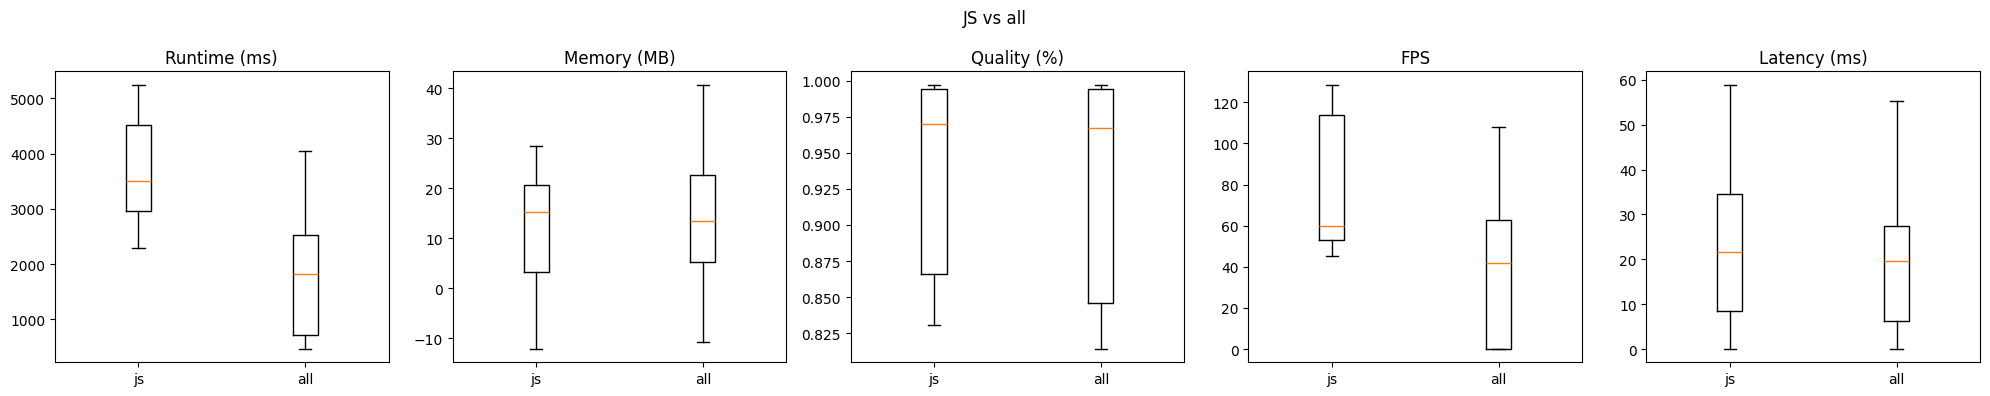

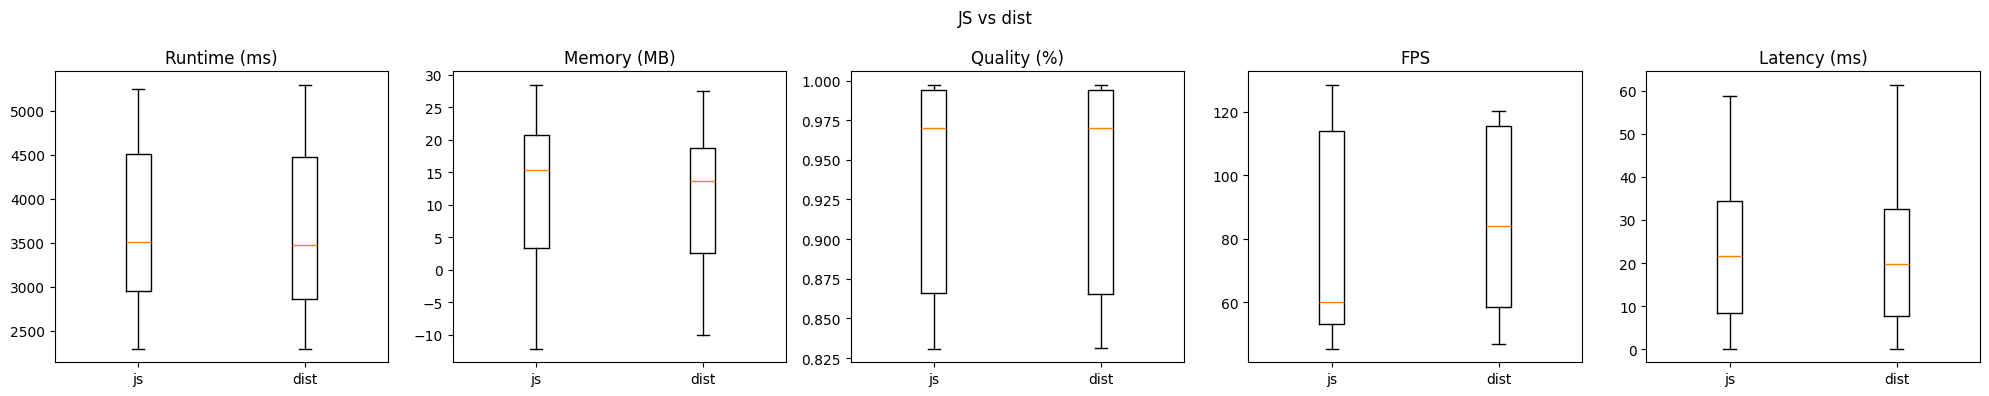

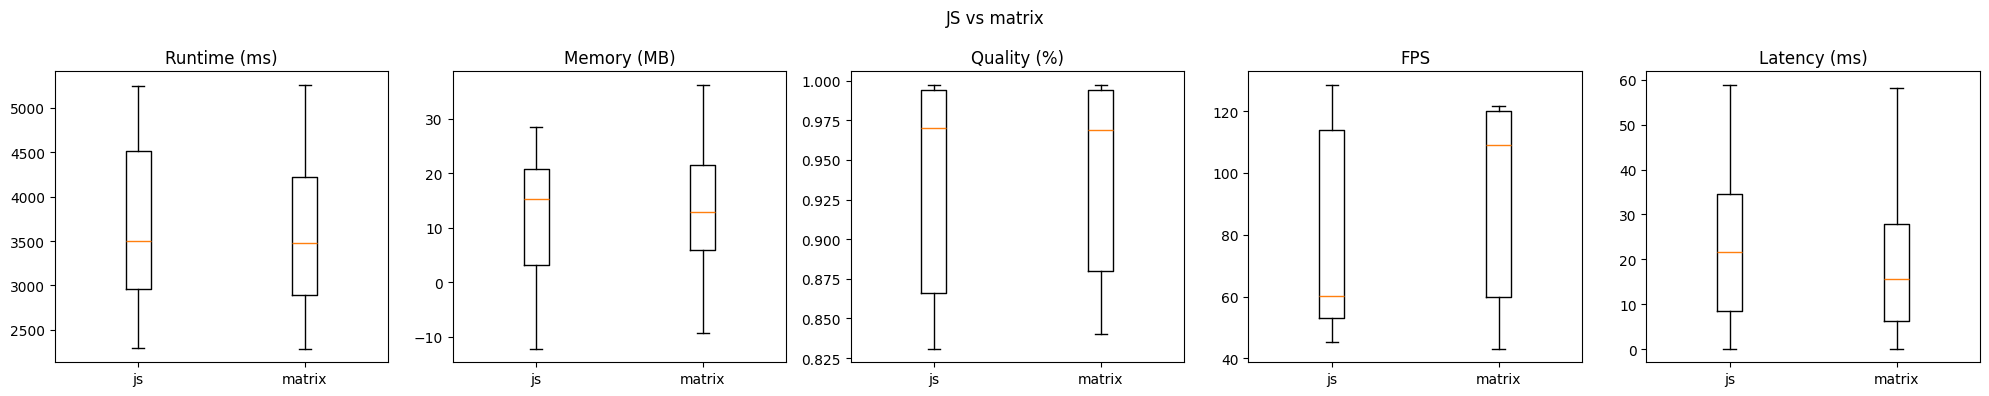

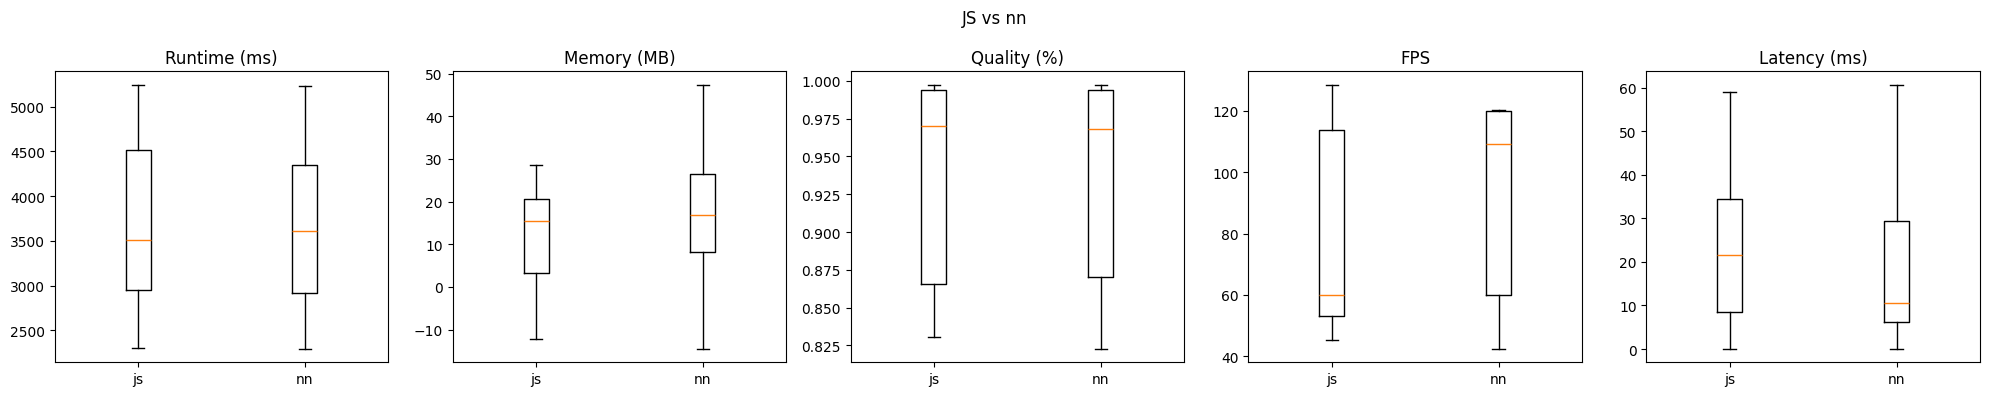

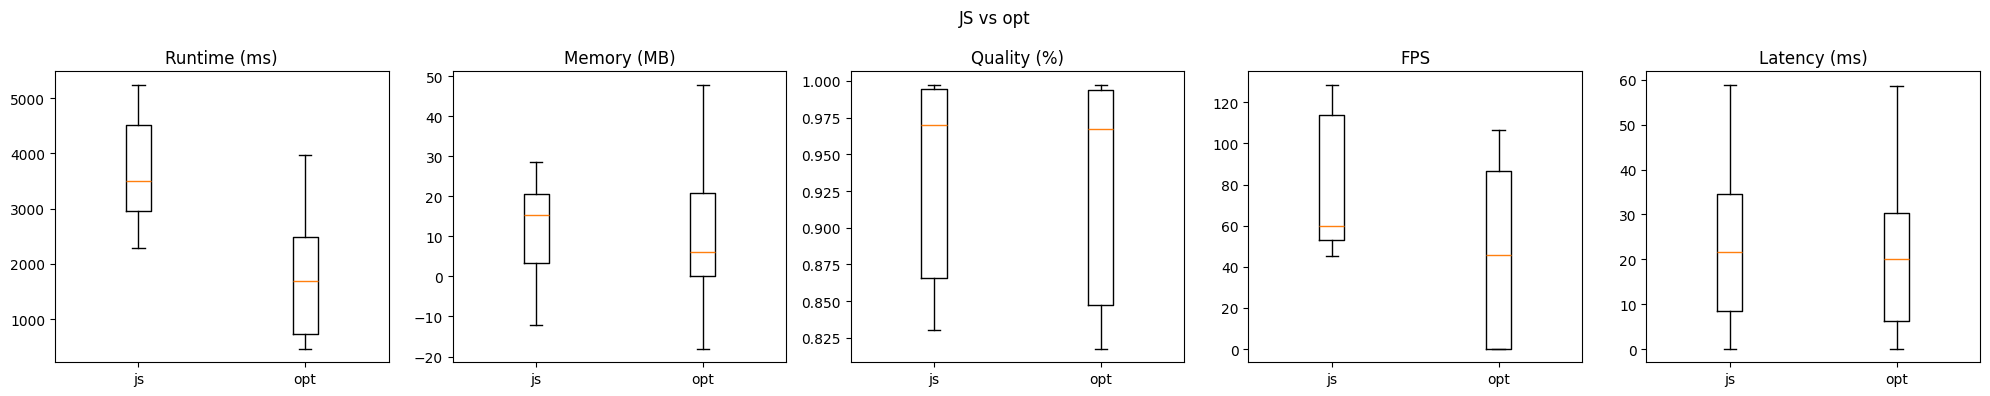

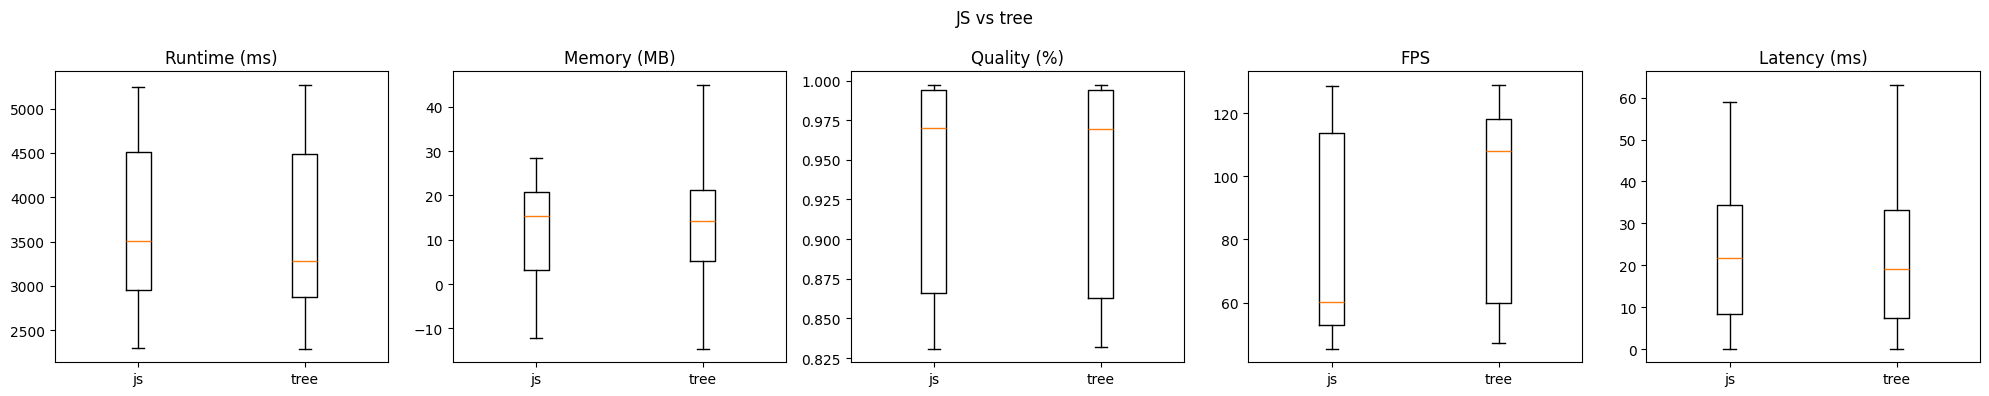

In [9]:
# JS vs each WASM feature (runtime/memory/quality/fps/latency)
metrics = ["Runtime (ms)", "Memory (MB)", "Quality (%)", "FPS", "Latency (ms)"]
modes = [m for m in sorted(df["wasm_mode"].unique()) if m != "js"]
for m in modes:
    subset = df[df["wasm_mode"].isin(["js", m])]
    fig, axes = plt.subplots(1, len(metrics), figsize=(4 * len(metrics), 4), sharey=False)
    fig.suptitle(f"JS vs {m}")
    for ax, metric in zip(axes, metrics):
        data_js = subset[subset["wasm_mode"] == "js"][metric].dropna()
        data_m = subset[subset["wasm_mode"] == m][metric].dropna()
        ax.boxplot([data_js, data_m], labels=["js", m], showfliers=False)
        ax.set_title(metric)
    plt.tight_layout()
    figs[f"js_vs_{m}"] = fig


/tmp/ipykernel_21969/3179435032.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data_js, data_w], labels=["js", "all_wasm"], showfliers=False)
/tmp/ipykernel_21969/3179435032.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data_js, data_w], labels=["js", "all_wasm"], showfliers=False)
/tmp/ipykernel_21969/3179435032.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data_js, data_w], labels=["js", "all_wasm"], showfliers=False)
/tmp/ipykernel_21969/3179435032.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Mat

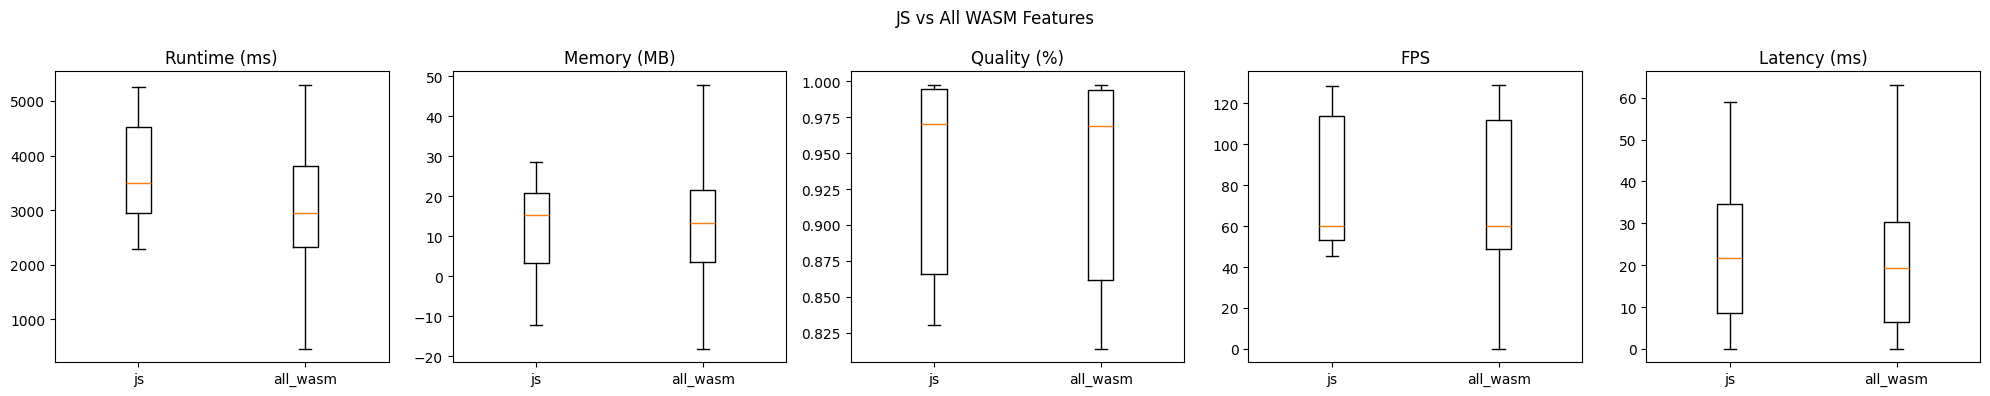

In [10]:
# JS vs all WASM (combined)
metrics = ["Runtime (ms)", "Memory (MB)", "Quality (%)", "FPS", "Latency (ms)"]
subset = df.copy()
subset["wasm_group"] = subset["wasm_mode"].apply(lambda x: "js" if x == "js" else "all_wasm")
fig, axes = plt.subplots(1, len(metrics), figsize=(4 * len(metrics), 4), sharey=False)
fig.suptitle("JS vs All WASM Features")
for ax, metric in zip(axes, metrics):
    data_js = subset[subset["wasm_group"] == "js"][metric].dropna()
    data_w = subset[subset["wasm_group"] == "all_wasm"][metric].dropna()
    ax.boxplot([data_js, data_w], labels=["js", "all_wasm"], showfliers=False)
    ax.set_title(metric)
plt.tight_layout()
figs["js_vs_all_wasm"] = fig


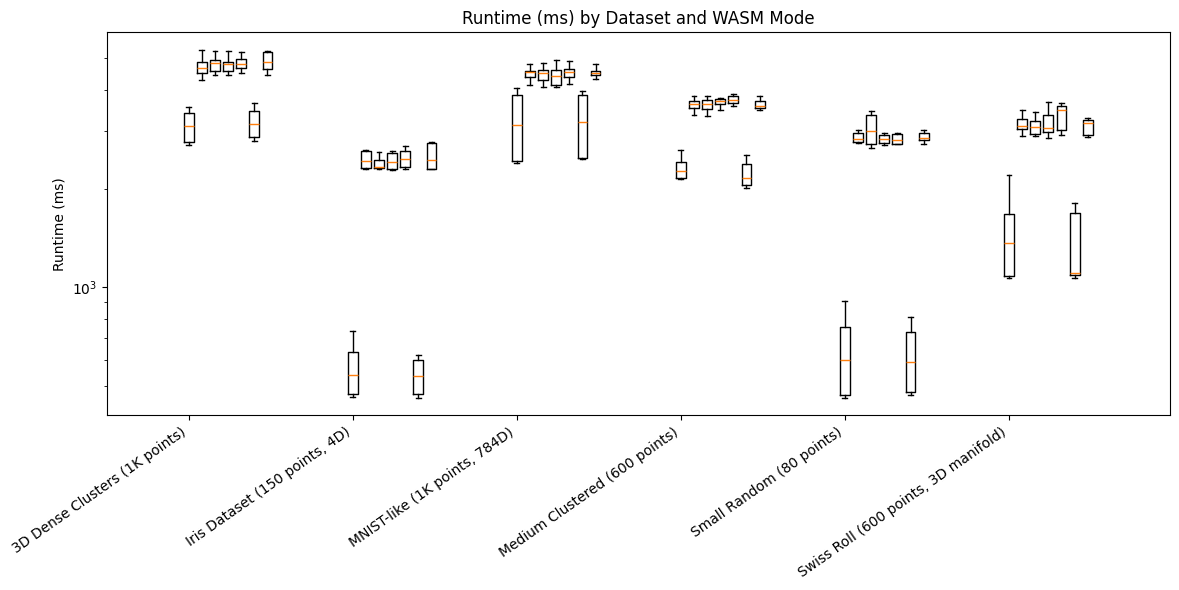

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
order = sorted(df["dataset_name"].unique())
positions = np.arange(len(order))

ax.set_title("Runtime (ms) by Dataset and WASM Mode")
for i, d in enumerate(order):
    subset = df[df["dataset_name"] == d]
    modes = sorted(subset["wasm_mode"].unique())
    for j, m in enumerate(modes):
        vals = subset[subset["wasm_mode"] == m]["Runtime (ms)"].dropna()
        if len(vals) == 0:
            continue
        ax.boxplot(vals, positions=[i + (j * 0.08)], widths=0.06, showfliers=False)

ax.set_xticks(positions)
ax.set_xticklabels(order, rotation=35, ha="right")
ax.set_ylabel("Runtime (ms)")
ax.set_yscale("log")
plt.tight_layout()
figs["runtime_boxplot"] = fig


Note: browser heap deltas are approximate and can be noisy across runs.


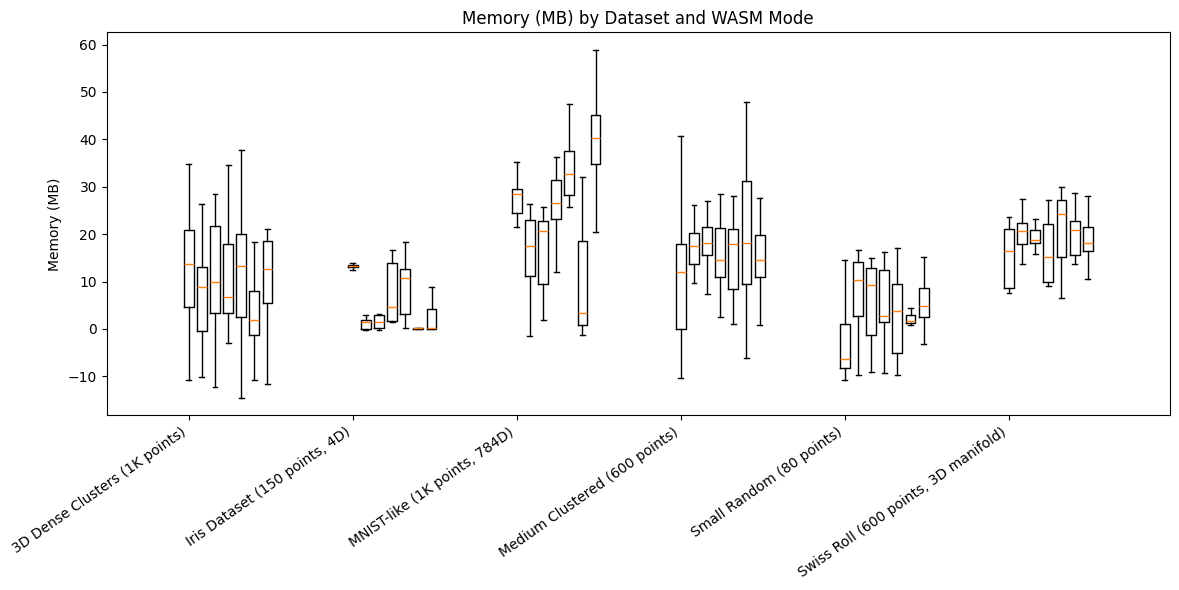

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))
order = sorted(df["dataset_name"].unique())
positions = np.arange(len(order))
ax.set_title("Memory (MB) by Dataset and WASM Mode")
for i, d in enumerate(order):
    subset = df[df["dataset_name"] == d]
    modes = sorted(subset["wasm_mode"].unique())
    for j, m in enumerate(modes):
        vals = subset[subset["wasm_mode"] == m]["Memory (MB)"].dropna()
        if len(vals) == 0:
            continue
        ax.boxplot(vals, positions=[i + (j * 0.08)], widths=0.06, showfliers=False)
ax.set_xticks(positions)
ax.set_xticklabels(order, rotation=35, ha="right")
ax.set_ylabel("Memory (MB)")
plt.tight_layout()
figs["memory_boxplot"] = fig


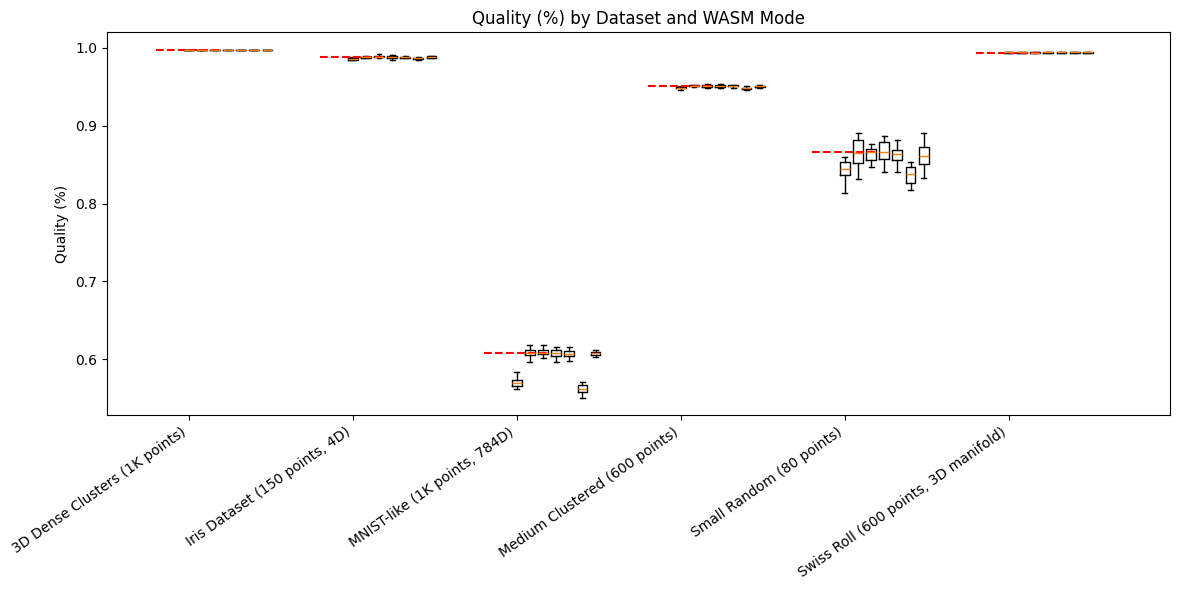

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
order = sorted(df["dataset_name"].unique())
positions = np.arange(len(order))
ax.set_title("Quality (%) by Dataset and WASM Mode")
for i, d in enumerate(order):
    subset = df[df["dataset_name"] == d]
    modes = sorted(subset["wasm_mode"].unique())
    for j, m in enumerate(modes):
        vals = subset[subset["wasm_mode"] == m]["Quality (%)"].dropna()
        if len(vals) == 0:
            continue
        ax.boxplot(vals, positions=[i + (j * 0.08)], widths=0.06, showfliers=False)
    if (subset["wasm_mode"] == "js").any():
        js_median = subset[subset["wasm_mode"] == "js"]["Quality (%)"].median()
        ax.hlines(js_median, i - 0.2, i + 0.2, colors="red", linestyles="dashed")
ax.set_xticks(positions)
ax.set_xticklabels(order, rotation=35, ha="right")
ax.set_ylabel("Quality (%)")
plt.tight_layout()
figs["quality_boxplot"] = fig


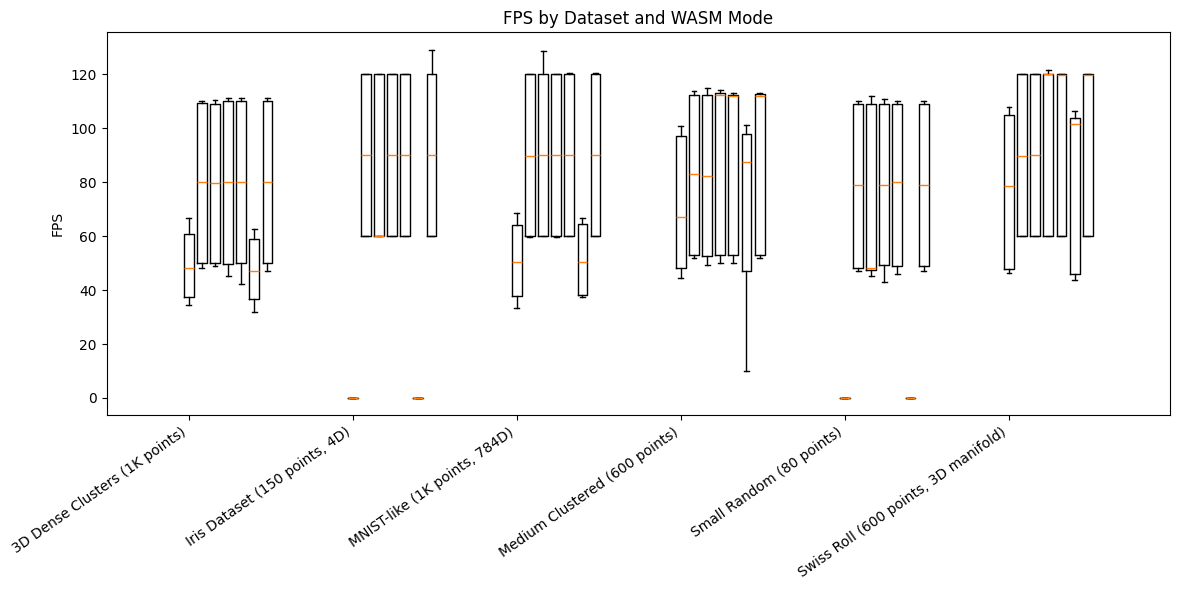

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
order = sorted(df["dataset_name"].unique())
positions = np.arange(len(order))
ax.set_title("FPS by Dataset and WASM Mode")
for i, d in enumerate(order):
    subset = df[df["dataset_name"] == d]
    modes = sorted(subset["wasm_mode"].unique())
    for j, m in enumerate(modes):
        vals = subset[subset["wasm_mode"] == m]["FPS"].dropna()
        if len(vals) == 0:
            continue
        ax.boxplot(vals, positions=[i + (j * 0.08)], widths=0.06, showfliers=False)
ax.set_xticks(positions)
ax.set_xticklabels(order, rotation=35, ha="right")
ax.set_ylabel("FPS")
plt.tight_layout()
figs["fps_boxplot"] = fig


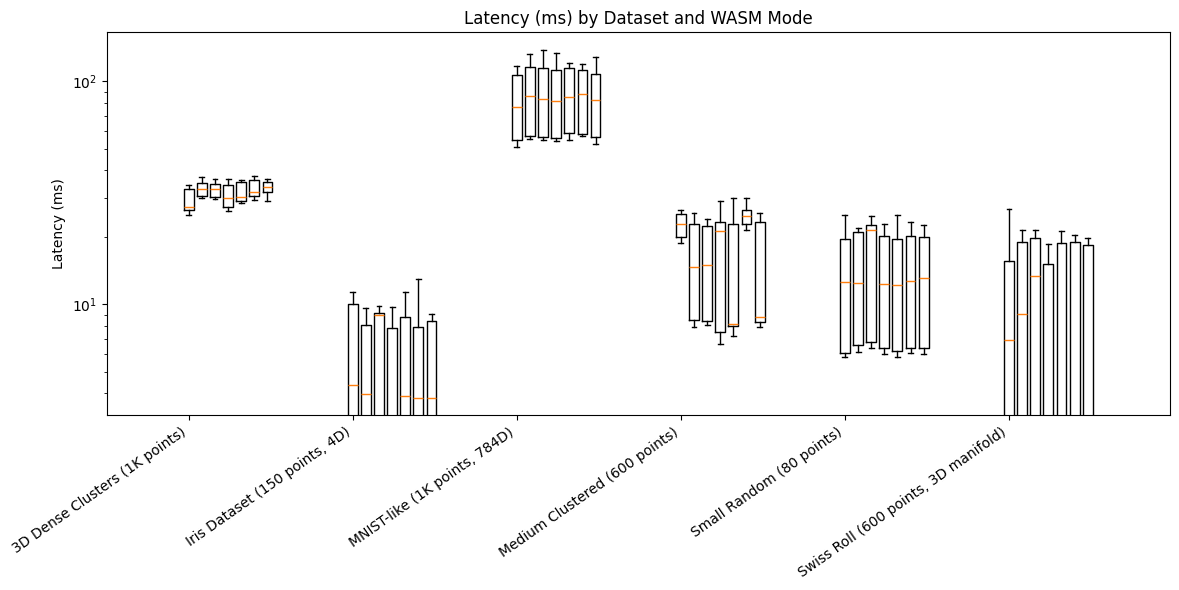

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
order = sorted(df["dataset_name"].unique())
positions = np.arange(len(order))
ax.set_title("Latency (ms) by Dataset and WASM Mode")
for i, d in enumerate(order):
    subset = df[df["dataset_name"] == d]
    modes = sorted(subset["wasm_mode"].unique())
    for j, m in enumerate(modes):
        vals = subset[subset["wasm_mode"] == m]["Latency (ms)"].dropna()
        if len(vals) == 0:
            continue
        ax.boxplot(vals, positions=[i + (j * 0.08)], widths=0.06, showfliers=False)
ax.set_yscale("log")
ax.set_xticks(positions)
ax.set_xticklabels(order, rotation=35, ha="right")
ax.set_ylabel("Latency (ms)")
plt.tight_layout()
figs["latency_boxplot"] = fig


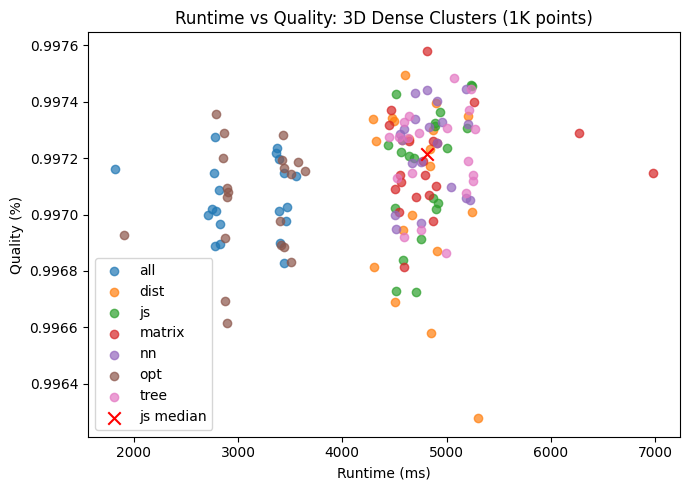

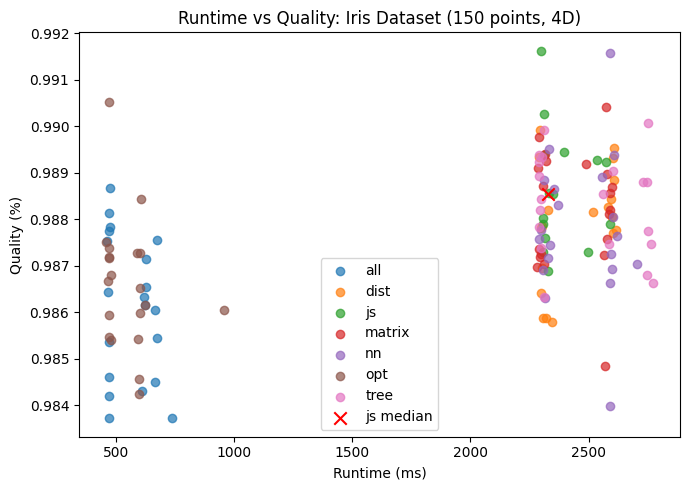

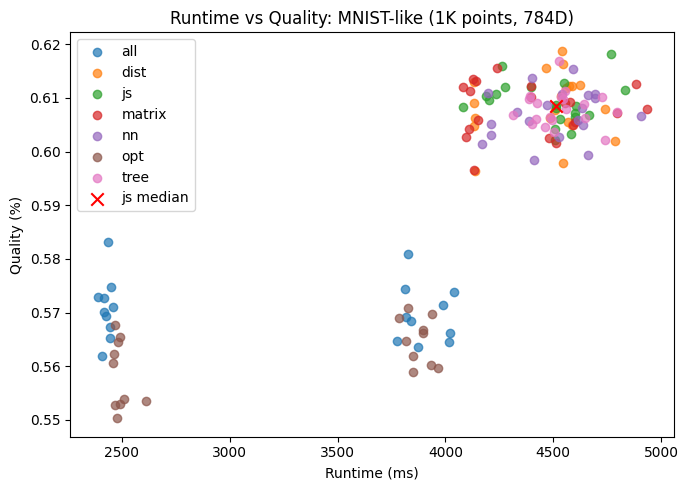

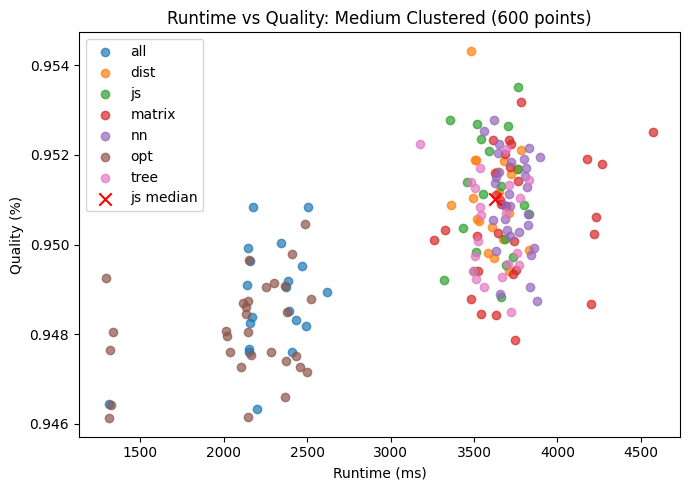

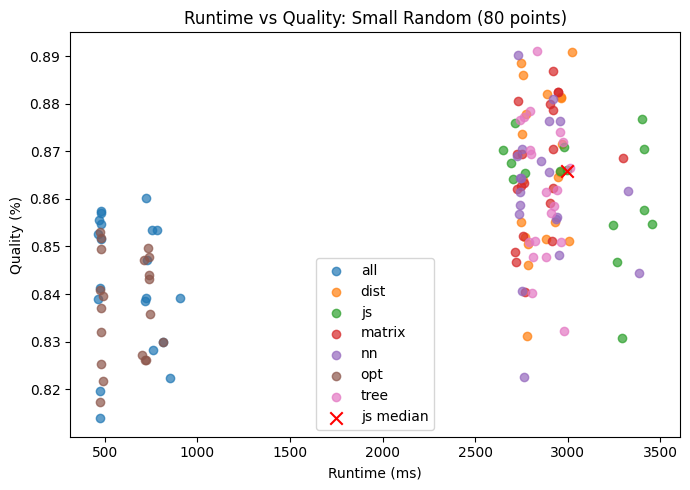

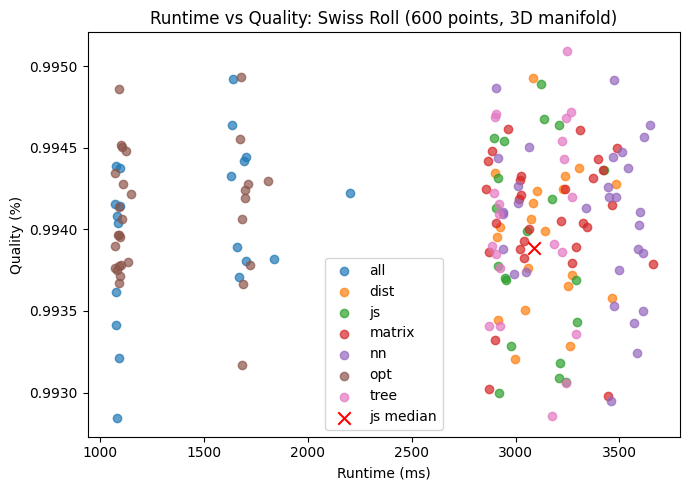

In [16]:
figs["runtime_quality"] = []
for d in sorted(df["dataset_name"].unique()):
    subset = df[df["dataset_name"] == d]
    fig, ax = plt.subplots(figsize=(7, 5))
    for m, s in subset.groupby("wasm_mode"):
        ax.scatter(s["Runtime (ms)"], s["Quality (%)"], label=m, alpha=0.7)
    if (subset["wasm_mode"] == "js").any():
        js = subset[subset["wasm_mode"] == "js"]
        ax.scatter(js["Runtime (ms)"].median(), js["Quality (%)"].median(), color="red", s=80, marker="x", label="js median")
    ax.set_title(f"Runtime vs Quality: {d}")
    ax.set_xlabel("Runtime (ms)")
    ax.set_ylabel("Quality (%)")
    ax.legend()
    plt.tight_layout()
    figs["runtime_quality"].append((d, fig))


Responsiveness proxy: FPS and latency capture UI smoothness and reaction time.


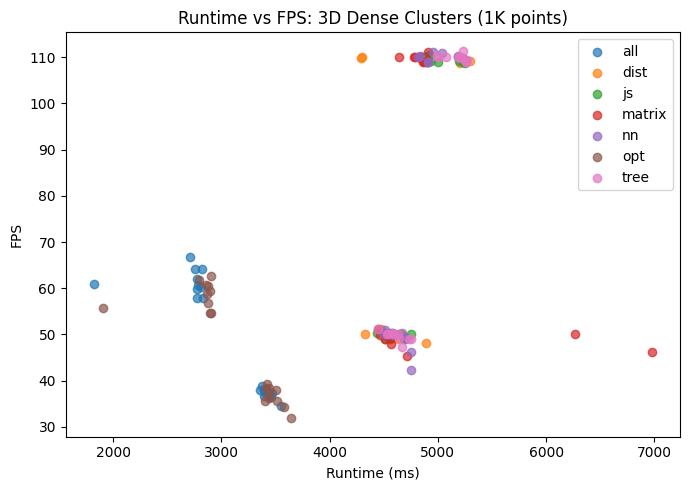

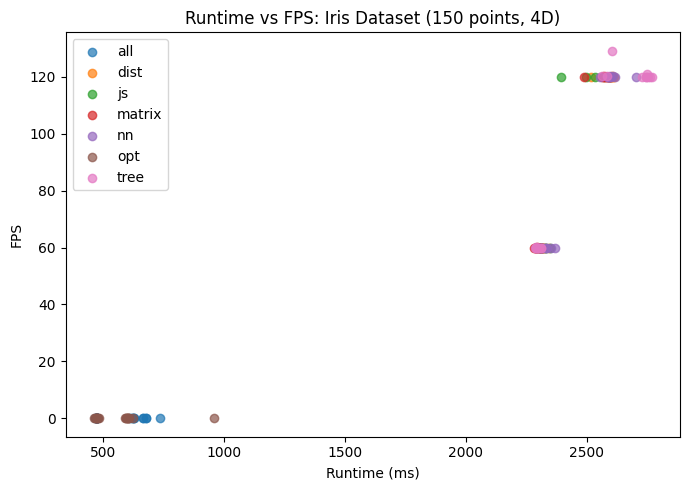

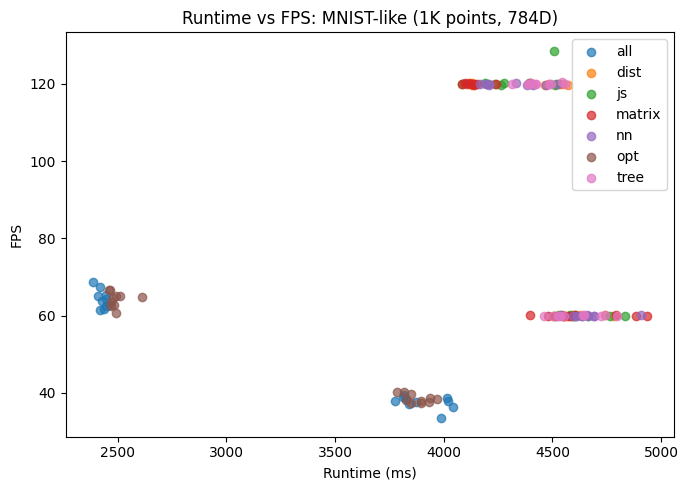

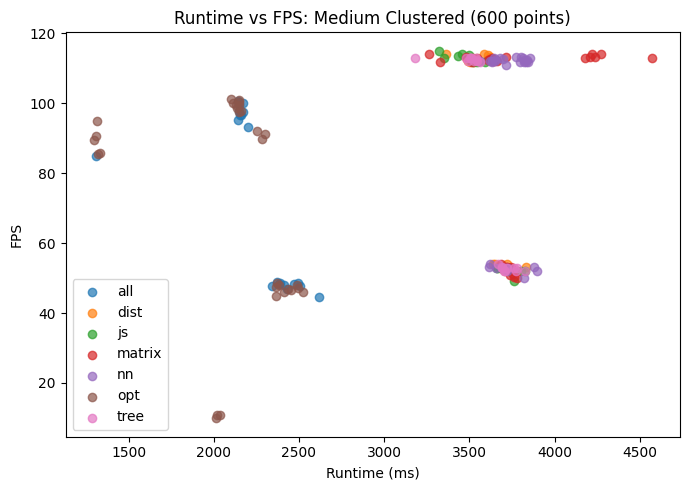

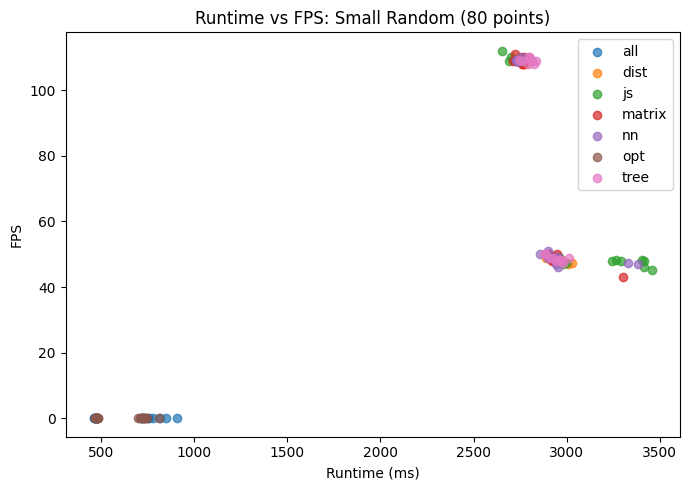

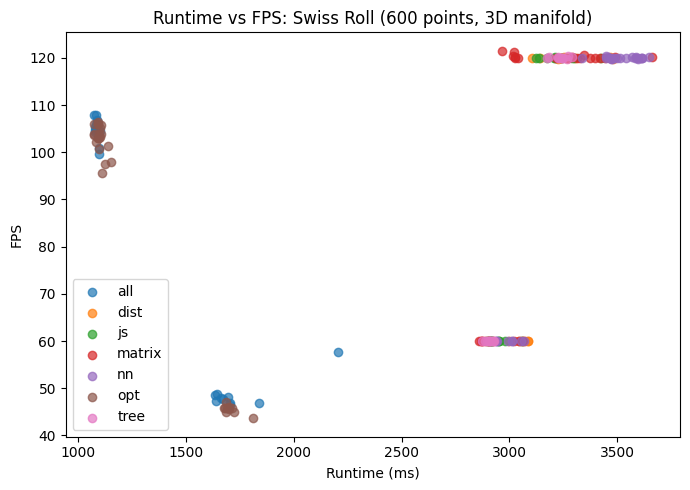

In [17]:
figs["runtime_fps"] = []
for d in sorted(df["dataset_name"].unique()):
    subset = df[df["dataset_name"] == d]
    fig, ax = plt.subplots(figsize=(7, 5))
    for m, s in subset.groupby("wasm_mode"):
        ax.scatter(s["Runtime (ms)"], s["FPS"], label=m, alpha=0.7)
    ax.set_title(f"Runtime vs FPS: {d}")
    ax.set_xlabel("Runtime (ms)")
    ax.set_ylabel("FPS")
    ax.legend()
    plt.tight_layout()
    figs["runtime_fps"].append((d, fig))


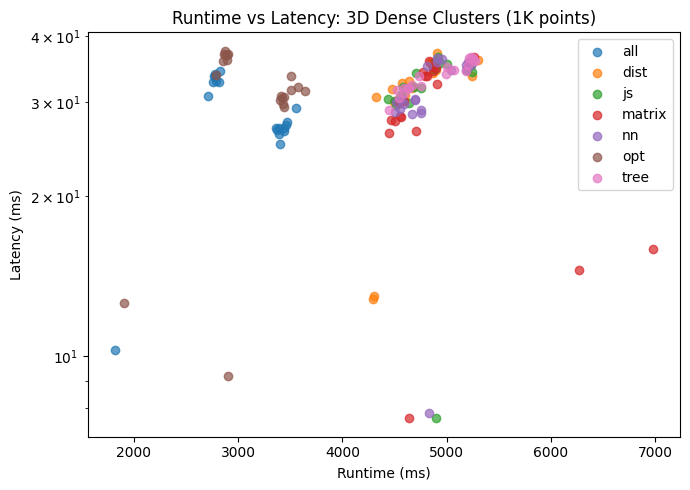

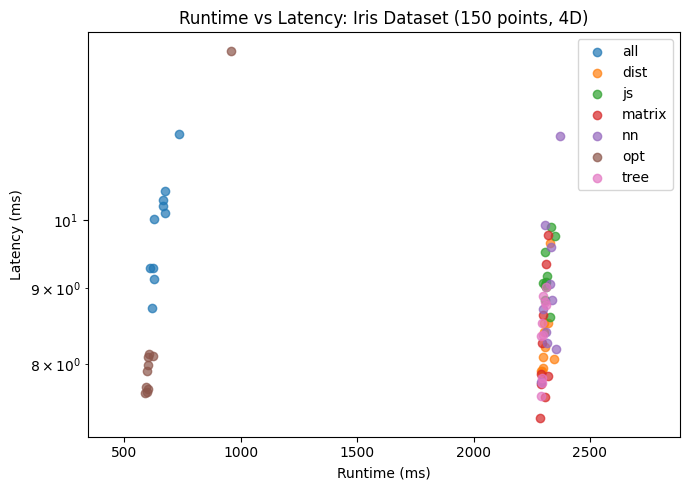

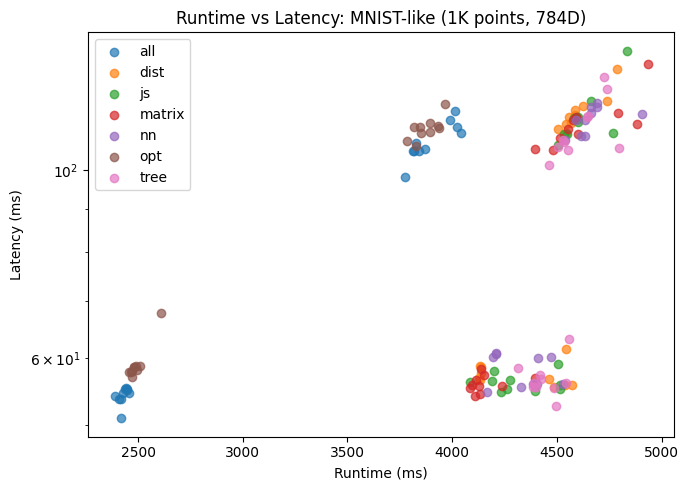

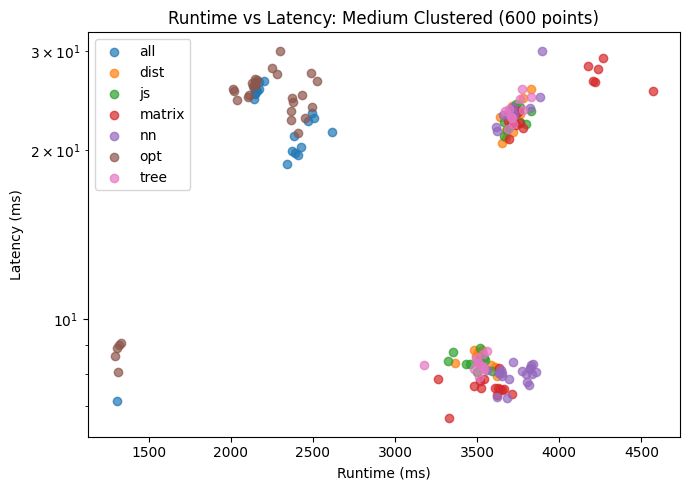

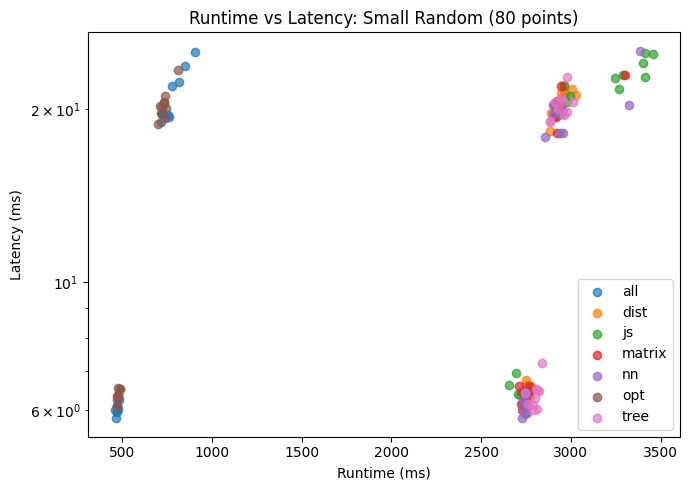

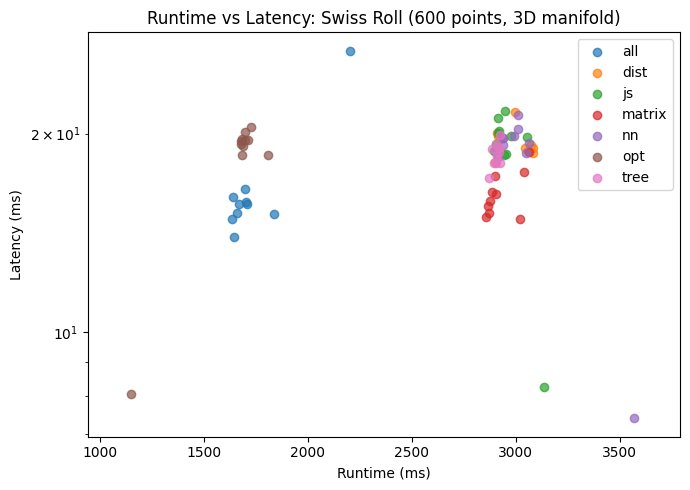

In [18]:
figs["runtime_latency"] = []
for d in sorted(df["dataset_name"].unique()):
    subset = df[df["dataset_name"] == d]
    fig, ax = plt.subplots(figsize=(7, 5))
    for m, s in subset.groupby("wasm_mode"):
        ax.scatter(s["Runtime (ms)"], s["Latency (ms)"], label=m, alpha=0.7)
    ax.set_title(f"Runtime vs Latency: {d}")
    ax.set_xlabel("Runtime (ms)")
    ax.set_ylabel("Latency (ms)")
    ax.set_yscale("log")
    ax.legend()
    plt.tight_layout()
    figs["runtime_latency"].append((d, fig))


In [20]:
def minmax_norm(series, maximize=True):
    x = series.astype(float)
    if x.max() == x.min():
        return pd.Series(0.0, index=x.index)
    if maximize:
        return (x - x.min()) / (x.max() - x.min())
    return (x.max() - x) / (x.max() - x.min())

pareto_results = []
for d, subset in df.groupby("dataset_name"):
    s = subset.copy()
    s["runtime_norm"] = minmax_norm(s["Runtime (ms)"], maximize=False)
    s["memory_norm"] = minmax_norm(s["Memory (MB)"], maximize=False)
    s["quality_norm"] = minmax_norm(s["Quality (%)"], maximize=True)
    s["fps_norm"] = minmax_norm(s["FPS"], maximize=True)
    s["latency_norm"] = minmax_norm(s["Latency (ms)"], maximize=False)
    s["composite_score"] = s[["runtime_norm", "memory_norm", "quality_norm", "fps_norm", "latency_norm"]].mean(axis=1)

    s = s.sort_values(["Runtime (ms)", "Quality (%)"])
    pareto = []
    best_quality = -np.inf
    for _, row in s.iterrows():
        if row["Quality (%)"] > best_quality:
            pareto.append(True)
            best_quality = row["Quality (%)"]
        else:
            pareto.append(False)
    s["pareto_runtime_quality"] = pareto

    top = s.sort_values("composite_score", ascending=False).head(5)
    top = top[["dataset_name", "wasm_mode", "Runtime (ms)", "Memory (MB)", "Quality (%)", "FPS", "Latency (ms)", "composite_score", "pareto_runtime_quality"]]
    pareto_results.append(top)

pareto_table = pd.concat(pareto_results, ignore_index=True)
pareto_table


,dataset_name,wasm_mode,Runtime (ms),Memory (MB),Quality (%),FPS,Latency (ms),composite_score,pareto_runtime_quality
0,3D Dense Clusters (1K points),nn,4832.6,-4.690277,0.997312,110.173697,7.840000,0.748837,False
1,3D Dense Clusters (1K points),matrix,4637.2,8.786073,0.997261,110.108124,7.653333,0.701286,False
2,3D Dense Clusters (1K points),all,2823.3,6.220775,0.996967,64.233577,0.000000,0.661146,False
3,3D Dense Clusters (1K points),tree,5234.9,-14.661837,0.997447,111.398448,36.526667,0.639738,False
4,3D Dense Clusters (1K points),dist,4293.8,26.304832,0.997338,109.857186,12.800000,0.635625,False
5,"Iris Dataset (150 points, 4D)",opt,471.6,0.119289,0.990532,0.000000,0.000000,0.767763,True
6,"Iris Dataset (150 points, 4D)",tree,2752.9,0.031504,0.990072,119.880120,0.000000,0.745276,False
7,"Iris Dataset (150 points, 4D)",dist,2602.7,-0.023188,0.989307,119.952019,0.000000,0.739652,False
8,"Iris Dataset (150 points, 4D)",js,2573.7,0.378485,0.989223,119.976005,0.000000,0.735723,False
9,"Iris Dataset (150 points, 4D)",js,2395.1,3.082266,0.989447,120.003967,0.000000,0.727662,False


In [21]:
def bootstrap_ci_median(x, n=2000, ci=0.95, seed=42):
    rng = np.random.default_rng(seed)
    x = x.dropna().to_numpy()
    if len(x) == 0:
        return (np.nan, np.nan)
    meds = []
    for _ in range(n):
        sample = rng.choice(x, size=len(x), replace=True)
        meds.append(np.median(sample))
    low = np.quantile(meds, (1 - ci) / 2)
    high = np.quantile(meds, 1 - (1 - ci) / 2)
    return (low, high, meds)

def bootstrap_speedup(mode_x, base_x, n=2000, seed=42):
    rng = np.random.default_rng(seed)
    mode_x = mode_x.dropna().to_numpy()
    base_x = base_x.dropna().to_numpy()
    if len(mode_x) == 0 or len(base_x) == 0:
        return (np.nan, np.nan, np.nan)
    vals = []
    for _ in range(n):
        m_sample = rng.choice(mode_x, size=len(mode_x), replace=True)
        b_sample = rng.choice(base_x, size=len(base_x), replace=True)
        m_med = np.median(m_sample)
        b_med = np.median(b_sample)
        vals.append(b_med / m_med if m_med != 0 else np.nan)
    low = np.nanquantile(vals, 0.025)
    high = np.nanquantile(vals, 0.975)
    point = np.nanmedian(vals)
    return (low, high, point)

ci_rows = []
for (d, m), subset in df.groupby(["dataset_name", "wasm_mode"]):
    med = subset["Runtime (ms)"].median()
    ci_low, ci_high, _ = bootstrap_ci_median(subset["Runtime (ms)"])
    base = df[(df["dataset_name"] == d) & (df["wasm_mode"] == "js")]["Runtime (ms)"]
    speed_low, speed_high, speed_point = bootstrap_speedup(subset["Runtime (ms)"], base)
    ci_rows.append({
        "dataset_name": d,
        "wasm_mode": m,
        "median_runtime": med,
        "median_runtime_ci_low": ci_low,
        "median_runtime_ci_high": ci_high,
        "speedup_ci_low": speed_low,
        "speedup_ci_high": speed_high,
        "speedup_point": speed_point
    })

ci_df = pd.DataFrame(ci_rows)
ci_df


,dataset_name,wasm_mode,median_runtime,median_runtime_ci_low,median_runtime_ci_high,speedup_ci_low,speedup_ci_high,speedup_point
0,3D Dense Clusters (1K points),all,3093.85,2782.60,3399.80,1.374898,1.750825,1.555748
1,3D Dense Clusters (1K points),dist,4650.55,4539.00,4860.95,0.963037,1.070169,1.024234
2,3D Dense Clusters (1K points),js,4813.25,4610.05,4909.35,0.950047,1.053752,1.000000
3,3D Dense Clusters (1K points),matrix,4785.70,4577.25,4866.95,0.961647,1.062033,1.009525
4,3D Dense Clusters (1K points),nn,4783.10,4680.30,4930.75,0.951840,1.042727,1.000639
5,3D Dense Clusters (1K points),opt,3152.40,2883.65,3435.05,1.359996,1.694443,1.526853
6,3D Dense Clusters (1K points),tree,4871.80,4633.10,5195.75,0.913963,1.050699,0.980571
7,"Iris Dataset (150 points, 4D)",all,542.30,473.15,626.60,3.695180,5.045502,4.269619
8,"Iris Dataset (150 points, 4D)",dist,2432.65,2305.65,2599.25,0.890186,1.026417,0.956529
9,"Iris Dataset (150 points, 4D)",js,2326.90,2307.70,2498.70,0.963509,1.037873,1.000000


In [22]:
def cliffs_delta(a, b):
    a = a.dropna().to_numpy()
    b = b.dropna().to_numpy()
    if len(a) == 0 or len(b) == 0:
        return np.nan
    gt = 0
    lt = 0
    for x in a:
        gt += np.sum(x > b)
        lt += np.sum(x < b)
    return (gt - lt) / (len(a) * len(b))

def holm_adjust(pvals):
    p = np.array([v if np.isfinite(v) else np.nan for v in pvals], dtype=float)
    n = np.sum(~np.isnan(p))
    order = np.argsort(p, kind="mergesort")
    adjusted = np.full_like(p, np.nan)
    for i, idx in enumerate(order):
        if np.isnan(p[idx]):
            continue
        adjusted[idx] = min(1.0, (n - i) * p[idx])
    return adjusted

test_rows = []
for d, subset in df.groupby("dataset_name"):
    js = subset[subset["wasm_mode"] == "js"]
    for m, s in subset.groupby("wasm_mode"):
        if m == "js":
            continue
        rt_p = stats.mannwhitneyu(s["Runtime (ms)"].dropna(), js["Runtime (ms)"].dropna(), alternative="two-sided").pvalue if len(js) and len(s) else np.nan
        lat_p = stats.mannwhitneyu(s["Latency (ms)"] .dropna(), js["Latency (ms)"].dropna(), alternative="two-sided").pvalue if len(js) and len(s) else np.nan
        test_rows.append({
            "dataset_name": d,
            "wasm_mode": m,
            "runtime_p": rt_p,
            "latency_p": lat_p,
            "runtime_delta_median": s["Runtime (ms)"].median() - js["Runtime (ms)"].median(),
            "latency_delta_median": s["Latency (ms)"].median() - js["Latency (ms)"].median(),
            "runtime_cliffs_delta": cliffs_delta(s["Runtime (ms)"], js["Runtime (ms)"]),
            "latency_cliffs_delta": cliffs_delta(s["Latency (ms)"], js["Latency (ms)"])
        })

tests = pd.DataFrame(test_rows)
if not tests.empty:
    tests["runtime_p_holm"] = holm_adjust(tests["runtime_p"].to_numpy())
    tests["latency_p_holm"] = holm_adjust(tests["latency_p"].to_numpy())
tests


,dataset_name,wasm_mode,runtime_p,latency_p,runtime_delta_median,latency_delta_median,runtime_cliffs_delta,latency_cliffs_delta,runtime_p_holm,latency_p_holm
0,3D Dense Clusters (1K points),all,6.795615e-08,0.002799,-1719.40,-5.676667,-1.000000,-0.555000,2.310509e-06,0.097951
1,3D Dense Clusters (1K points),dist,2.732851e-01,0.989209,-162.70,-0.316667,-0.205000,0.005000,1.000000e+00,0.989209
2,3D Dense Clusters (1K points),matrix,6.750142e-01,0.088337,-27.55,-3.023333,-0.080000,-0.317500,1.000000e+00,1.000000
3,3D Dense Clusters (1K points),nn,7.971974e-01,0.490334,-30.15,-2.660000,0.050000,-0.130000,1.000000e+00,1.000000
4,3D Dense Clusters (1K points),opt,6.795615e-08,0.818149,-1660.85,-1.236667,-1.000000,0.045000,2.242553e-06,1.000000
5,3D Dense Clusters (1K points),tree,3.104023e-01,0.401698,58.55,0.666667,0.190000,0.157500,1.000000e+00,1.000000
6,"Iris Dataset (150 points, 4D)",all,6.249815e-07,0.848545,-1784.60,-4.650000,-1.000000,0.040000,1.749948e-05,1.000000
7,"Iris Dataset (150 points, 4D)",dist,3.770562e-01,0.020940,105.75,-5.054545,0.180000,-0.446667,1.000000e+00,0.544436
8,"Iris Dataset (150 points, 4D)",matrix,8.414696e-01,0.035498,77.25,-9.009091,0.043333,-0.403333,1.000000e+00,0.816457
9,"Iris Dataset (150 points, 4D)",nn,6.429488e-02,0.170203,137.40,-5.118182,0.373333,-0.266667,1.000000e+00,1.000000


In [23]:
def extract_size(name):
    name = str(name).lower()
    patterns = [
        r"ns*=s*(d+)",
        r"rowss*=s*(d+)",
        r"(d+)s*points",
        r"(d+)x(d+)",
        r"(d+)s*rows",
    ]
    for p in patterns:
        m = re.search(p, name)
        if m:
            if len(m.groups()) == 2:
                return float(m.group(1))
            return float(m.group(1))
    return np.nan

df["dataset_size_extracted"] = df["dataset_name"].apply(extract_size)
if df["dataset_size_extracted"].notna().sum() == 0:
    print("No size metadata detected; scaling analysis skipped.")
else:
    fig, ax = plt.subplots(figsize=(8, 5))
    for m, s in df.dropna(subset=["dataset_size_extracted"]).groupby("wasm_mode"):
        ax.plot(s["dataset_size_extracted"], s["Runtime (ms)"], marker="o", linestyle="-", label=m)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title("Runtime vs Dataset Size (log-log)")
    ax.set_xlabel("Dataset size (extracted)")
    ax.set_ylabel("Runtime (ms)")
    ax.legend()
    plt.tight_layout()
    figs["scaling_runtime"] = fig

    if sm is not None:
        s = df.dropna(subset=["dataset_size_extracted"]).copy()
        s["log_runtime"] = np.log(s["Runtime (ms)"])
        s["log_size"] = np.log(s["dataset_size_extracted"])
        X = pd.get_dummies(s[["log_size", "wasm_mode"]], drop_first=True)
        X = sm.add_constant(X)
        model = sm.OLS(s["log_runtime"], X).fit()
        print(model.summary())


No size metadata detected; scaling analysis skipped.


### WASM feature contribution ranking

We aggregate across datasets using medians and apply a simple rule-based scoring for “best speed” and “best balanced.”


In [24]:
agg = df_cmp.groupby("wasm_mode").agg({
    "runtime_speedup": "median",
    "memory_delta_mb": "median",
    "quality_delta": "median",
    "fps_delta": "median",
    "latency_delta_ms": "median"
}).reset_index()

agg["score_speed"] = agg["runtime_speedup"]
agg["score_balanced"] = agg["runtime_speedup"] - 0.01 * agg["latency_delta_ms"] + 0.01 * agg["fps_delta"] + 0.01 * agg["quality_delta"] - 0.001 * agg["memory_delta_mb"]

best_speed = agg.sort_values("score_speed", ascending=False).head(5)
best_balanced = agg.sort_values("score_balanced", ascending=False).head(5)

best_speed, best_balanced


(  wasm_mode  runtime_speedup  memory_delta_mb  quality_delta  fps_delta  latency_delta_ms  score_speed  score_balanced
 0       all         1.859657         2.392665      -0.002309 -42.279417         -1.215000     1.859657        1.446597
 5       opt         1.834587        -3.186819      -0.002295 -41.409209         -1.441667     1.834587        1.438075
 6      tree         1.011219        -0.096659      -0.000024  29.339989         -1.383788     1.011219        1.318554
 3    matrix         1.006934         0.291780       0.000037  29.811478         -5.956667     1.006934        1.364324
 1      dist         1.004211        -0.064854      -0.000131  15.533018         -1.345000     1.004211        1.173055,
   wasm_mode  runtime_speedup  memory_delta_mb  quality_delta  fps_delta  latency_delta_ms  score_speed  score_balanced
 0       all         1.859657         2.392665      -0.002309 -42.279417         -1.215000     1.859657        1.446597
 5       opt         1.834587        -3

### Thesis-ready summary generator

This cell creates a conservative narrative summary aligned with RQ1–RQ3.


In [25]:
from IPython.display import Markdown, display

overall_speedup = agg.sort_values("runtime_speedup", ascending=False).head(3)
regressions = agg.sort_values("runtime_speedup", ascending=True).head(3)

summary_lines = []
summary_lines.append("#### Summary (auto-generated)")
summary_lines.append("")
summary_lines.append("Overall best speedups (median across datasets):")
for _, r in overall_speedup.iterrows():
    summary_lines.append(f"- {r["wasm_mode"]}: median speedup {r["runtime_speedup"]:.2f}x")
summary_lines.append("")
summary_lines.append("Notable regressions / slower configs:")
for _, r in regressions.iterrows():
    summary_lines.append(f"- {r["wasm_mode"]}: median speedup {r["runtime_speedup"]:.2f}x")
summary_lines.append("")
summary_lines.append("RQ1: We observed runtime and memory differences across WASM feature sets; these results reflect this benchmark only.")
summary_lines.append("RQ2: Scaling patterns are approximated where dataset size can be inferred from names; otherwise scaling is not evaluated.")
summary_lines.append("RQ3: Quality and responsiveness trade-offs vary by dataset; quality and memory are approximate in a browser context.")

summary_md = "".join(summary_lines)
display(Markdown(summary_md))


#### Summary (auto-generated)Overall best speedups (median across datasets):- all: median speedup 1.86x- opt: median speedup 1.83x- tree: median speedup 1.01xNotable regressions / slower configs:- nn: median speedup 0.99x- js: median speedup 1.00x- dist: median speedup 1.00xRQ1: We observed runtime and memory differences across WASM feature sets; these results reflect this benchmark only.RQ2: Scaling patterns are approximated where dataset size can be inferred from names; otherwise scaling is not evaluated.RQ3: Quality and responsiveness trade-offs vary by dataset; quality and memory are approximate in a browser context.

In [26]:
import os
output_dir = "analysis_outputs"
os.makedirs(output_dir, exist_ok=True)

summary.to_csv(os.path.join(output_dir, "grouped_summary.csv"), index=False)
delta_summary.reset_index().to_csv(os.path.join(output_dir, "delta_summary.csv"), index=False)
agg.to_csv(os.path.join(output_dir, "wasm_feature_ranking.csv"), index=False)
pareto_table.to_csv(os.path.join(output_dir, "pareto_table.csv"), index=False)
ci_df.to_csv(os.path.join(output_dir, "bootstrap_ci.csv"), index=False)
tests.to_csv(os.path.join(output_dir, "hypothesis_tests.csv"), index=False)

def _slug(s):
    return re.sub(r"[^a-z0-9]+", "_", s.lower()).strip("_")

for name, fig in figs.items():
    if isinstance(fig, list):
        for label, f in fig:
            fname = f"{name}_{_slug(label)}.png"
            f.savefig(os.path.join(output_dir, fname), dpi=300)
    else:
        fig.savefig(os.path.join(output_dir, f"{name}.png"), dpi=300)

with open(os.path.join(output_dir, "results_overview.md"), "w", encoding="utf-8") as f:
    f.write(summary_md + "\n\n")
    f.write("## Grouped Summary (head)\n\n")
    f.write(summary.head(10).to_markdown(index=False))
    f.write("\n\n## Delta Summary (head)\n\n")
    f.write(delta_summary.reset_index().head(10).to_markdown(index=False))


In [27]:
import sys
from datetime import datetime

print("python version:", sys.version)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("timestamp:", datetime.utcnow().isoformat() + "Z")
print("rows analyzed:", len(df))
print("Reminder: rerun after regenerating benchmark CSVs.")


python version: 3.12.3 (main, Jan  8 2026, 11:30:50) [GCC 13.3.0]
pandas version: 2.3.3
numpy version: 2.4.1
timestamp: 2026-02-06T02:32:42.578755Z
rows analyzed: 892
Reminder: rerun after regenerating benchmark CSVs.


/tmp/ipykernel_21969/2859574035.py:7: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  print("timestamp:", datetime.utcnow().isoformat() + "Z")
